In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime, timezone
import pandas as pd
import json
import fitsio
import time
import pickle
import re

%reload_ext autoreload
%autoreload 2

In [2]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.coreRL.offline_dataset import OfflineDELVEDataset

from survey_ops.coreRL.agents import Agent
from survey_ops.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.sys_utils import seed_everything
from survey_ops.coreRL.data_processing import load_raw_data_to_dataframe


In [3]:
from survey_ops.coreRL.data_processing import get_nautical_twilight, get_sun_rise_and_set_azel

In [4]:
from survey_ops.utils import ephemerides
from tqdm import tqdm
from pathlib import Path

In [5]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from collections import Counter
from scipy.stats import entropy

In [6]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

# Load config and lookup files

In [7]:
results_outdir = '../experiment_results/bc-azel-4years/'
eval_outdir = results_outdir + 'evaluation_1/'

In [8]:
with open('../configs/global_config.json', 'r') as f:
    gcfg = json.load(f)

In [9]:
with open(results_outdir + 'config.json', 'r') as f:
    cfg = json.load(f)

In [10]:
nside = cfg['data']['nside']

In [44]:
with open('../data/lookups/offlineDELVE_visit_history.pkl', 'rb') as f:
    night2visithistory = pickle.load(f)

with open('../data/lookups/field2radec.json', 'r') as f:
    field2radec = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2radec.json', 'r') as f:
    bin2radec = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2azel.json', 'r') as f:
    bin2azel = json.load(f)

with open(f'../data/lookups/nside{nside}_bin2fields_in_bin.json', 'r') as f:
    bin2fields_in_bin = json.load(f)

with open(f'../data/lookups/field2nvisits.json', "r") as f:
    field2nvisits = json.load(f)
    
with open(f'../data/lookups/field2name.json', "r") as f:
    field2name = json.load(f)

In [32]:
# fits_path = Path(cfg.get('paths.DFITS')).resolve().parents[1] / 'data' / cfg.get('paths.DFITS')
# json_path = Path(cfg.get('paths.DJSON')).resolve().parents[1] / 'data' / cfg.get('paths.DJSON')

df = load_raw_data_to_dataframe(fits_path='../data/fits/decam-exposures-20251211.fits')

d = OfflineDELVEDataset(
    df=df,
    cfg=cfg,
    gcfg=gcfg,
)

Calculating sun and moon ra/dec and az/el: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54030/54030 [00:44<00:00, 1206.57it/s]
Calculating bin features for all healpix bins and timestamps: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54030/54030 [00:00<00:00, 9330077.20it/s]


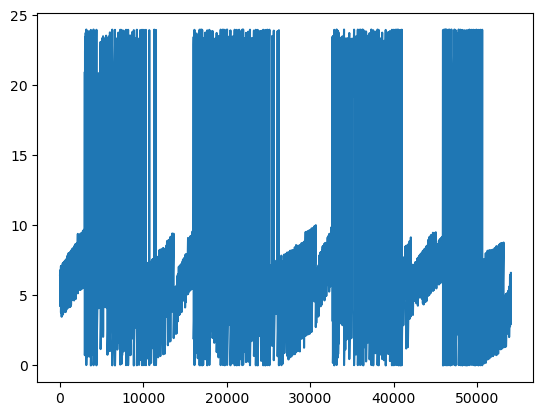

In [36]:
plt.plot(d._df['lst_hours'].values)

In [65]:
df = load_raw_data_to_dataframe(fits_path='../data/fits/decam-exposures-20251211.fits')

In [69]:
from survey_ops.coreRL.data_processing import drop_rows_in_DECam_data

In [70]:
df = drop_rows_in_DECam_data(df, objects_to_remove=["guide", "DES vvds","J0'","gwh","DESGW","Alhambra-8","cosmos","COSMOS hex","TMO","LDS","WD0","DES supernova hex","NGC","ec", "(outlier)"])

/home/hurra/Projects/survey-ops/survey_ops/coreRL/data_processing.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  from collections import defaultdict


In [71]:
df[df['night'] == df['night'].unique()[-1]]['object']

88135     DES survey hex 657-663 tiling 8
88136     DES survey hex 611-674 tiling 6
88137     DES survey hex 611-674 tiling 9
88138     DES survey hex 497-663 tiling 5
88139     DES survey hex 418-663 tiling 5
88140     DES survey hex 457-653 tiling 3
88141     DES survey hex 418-663 tiling 1
88142     DES survey hex 577-663 tiling 8
88143     DES survey hex 497-663 tiling 8
88144     DES survey hex 418-663 tiling 8
88145     DES survey hex 418-663 tiling 8
88146     DES survey hex 418-663 tiling 8
88147    DES survey hex 338-663 tiling 10
88148     DES survey hex 338-663 tiling 5
88149     DES survey hex 380-653 tiling 3
88150     DES survey hex 418-663 tiling 1
88151     DES survey hex 418-663 tiling 5
88152     DES survey hex 457-653 tiling 3
88153     DES survey hex 497-663 tiling 8
88154     DES survey hex 497-663 tiling 5
88155     DES survey hex 541-674 tiling 6
88156     DES survey hex 577-663 tiling 8
88157     DES survey hex 611-674 tiling 6
88158     DES survey hex 657-663 t

In [59]:
df['night'].unique()[-1]

Timestamp('2019-01-09 00:00:00+0000', tz='UTC')

In [37]:
with open(eval_outdir + 'eval_metrics.pkl', 'rb') as f:
    eval_metrics = pickle.load(f)

In [41]:
eval_metrics['ep-0']['field_id']['night-0']

array([   -1, 11094, 12975, 12463, 12485,  2485,  2709, 13030, 10209,
         722, 10276, 15794, 15221, 15220, 10932,  8364, 14194,  3524,
       10222, 10933, 15831, 10770,  2949,  6234,  2924,  2924, 15909,
       14209, 10689,  5727,  3918,  3676,  3919,  3920,  3925,  3927])

In [42]:
field2nvisits 

{'0': 4,
 '1': 5,
 '2': 5,
 '3': 5,
 '4': 5,
 '5': 5,
 '6': 5,
 '7': 5,
 '8': 5,
 '9': 5,
 '10': 4,
 '11': 4,
 '12': 3,
 '13': 4,
 '14': 3,
 '15': 4,
 '16': 5,
 '17': 5,
 '18': 4,
 '19': 4,
 '20': 4,
 '21': 4,
 '22': 3,
 '23': 4,
 '24': 4,
 '25': 4,
 '26': 4,
 '27': 4,
 '28': 5,
 '29': 4,
 '30': 5,
 '31': 4,
 '32': 4,
 '33': 4,
 '34': 4,
 '35': 4,
 '36': 4,
 '37': 5,
 '38': 4,
 '39': 5,
 '40': 4,
 '41': 4,
 '42': 5,
 '43': 5,
 '44': 5,
 '45': 5,
 '46': 5,
 '47': 5,
 '48': 5,
 '49': 5,
 '50': 5,
 '51': 4,
 '52': 4,
 '53': 5,
 '54': 5,
 '55': 5,
 '56': 5,
 '57': 5,
 '58': 5,
 '59': 4,
 '60': 6,
 '61': 5,
 '62': 6,
 '63': 4,
 '64': 5,
 '65': 4,
 '66': 5,
 '67': 5,
 '68': 6,
 '69': 6,
 '70': 5,
 '71': 5,
 '72': 5,
 '73': 5,
 '74': 5,
 '75': 6,
 '76': 4,
 '77': 7,
 '78': 4,
 '79': 5,
 '80': 4,
 '81': 5,
 '82': 5,
 '83': 4,
 '84': 5,
 '85': 5,
 '86': 5,
 '87': 4,
 '88': 5,
 '89': 4,
 '90': 6,
 '91': 5,
 '92': 4,
 '93': 5,
 '94': 5,
 '95': 5,
 '96': 6,
 '97': 5,
 '98': 5,
 '99': 5,
 '100': 6,